In [496]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import os
import datetime
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
import dateutil
import seaborn as sns
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import StratifiedKFold

#set pwd
dirpath = os.getcwd()
print("current directory is : " + dirpath)
foldername = os.path.basename(dirpath)
print("Directory name is : " + foldername)

current directory is : C:\Users\D4rkmatter\Documents\GitHub\insurance-claim-forecast
Directory name is : insurance-claim-forecast


<h1>Claim Data</h1>

In [332]:
claimdata=pd.read_csv('claimdata.csv')
#Clean Data to months
claimdata['ClaimDate'] =  pd.to_datetime(claimdata['ClaimDate'])
claimdata['ClaimDate'] = claimdata['ClaimDate'].dt.strftime('%b %Y') #Consider dropping year for training (year may not be important) --> false
claimdata['ClaimAmount'] = claimdata['ClaimAmount'].round()
claimdata.shape

(37049, 4)

<h2>Consolidate Claims into same month</h2>

In [273]:
group = claimdata.groupby(['PetId','ClaimDate'])
claimdata = group.aggregate(np.sum)
claimdata = claimdata.reset_index()

In [5]:
claimdata.shape

(22700, 4)

<h2>Claimdata Simple Exploration</h2>

In [6]:
claimdata.ClaimAmount.describe()
#claimdata.ClaimAmount.median()

count    22700.000000
mean       664.278259
std       1522.820667
min          1.400000
25%         90.317500
50%        217.945000
75%        559.372500
max      48691.460000
Name: ClaimAmount, dtype: float64

In [642]:
claimdata

,ClaimId,PetId,ClaimDate,ClaimAmount
0,0,9273,Feb 2014,390.0
1,1,1988,Mar 2014,455.0
2,2,2452,Apr 2014,1954.0
3,3,3658,Apr 2014,244.0
4,5,9147,Mar 2014,206.0
...,...,...,...,...
37044,40432,7120,May 2017,172.0
37045,40433,4991,Aug 2017,200.0
37046,40434,1984,Apr 2017,25.0
37047,40435,4941,Sep 2015,180.0


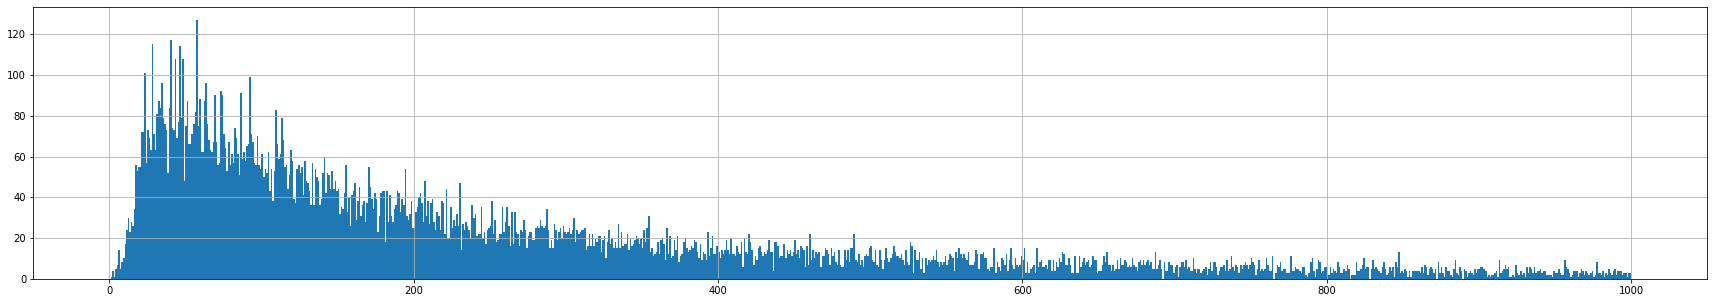

In [8]:
claimdata.ClaimAmount.hist(bins=1000,figsize=(30,5),range=(0,1000)) #3 std ~= 3500


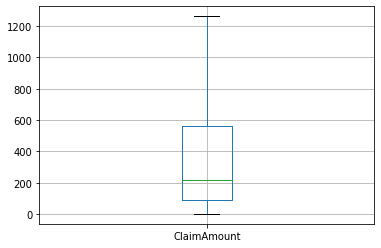

In [9]:
claimdata.boxplot(column='ClaimAmount',showfliers=False)

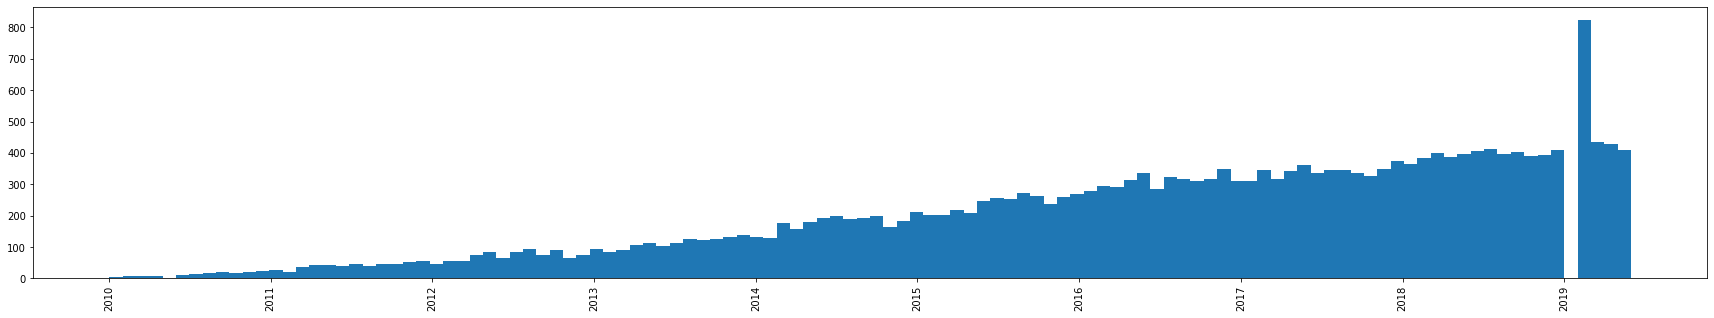

In [10]:
temp = claimdata
#reset dates for sorting
temp.ClaimDate = pd.to_datetime(temp.ClaimDate)
temp.sort_index(inplace=True)
temp.ClaimDate.hist(figsize=(30,5),grid=False, bins=len(temp.ClaimDate.unique()))
plt.xticks(rotation='vertical')
plt.show()

#NOTE, Year must stay
#NOTE, must reset strftime dates?

In [11]:
claimdata['ClaimDate'].isnull().values.any()

False

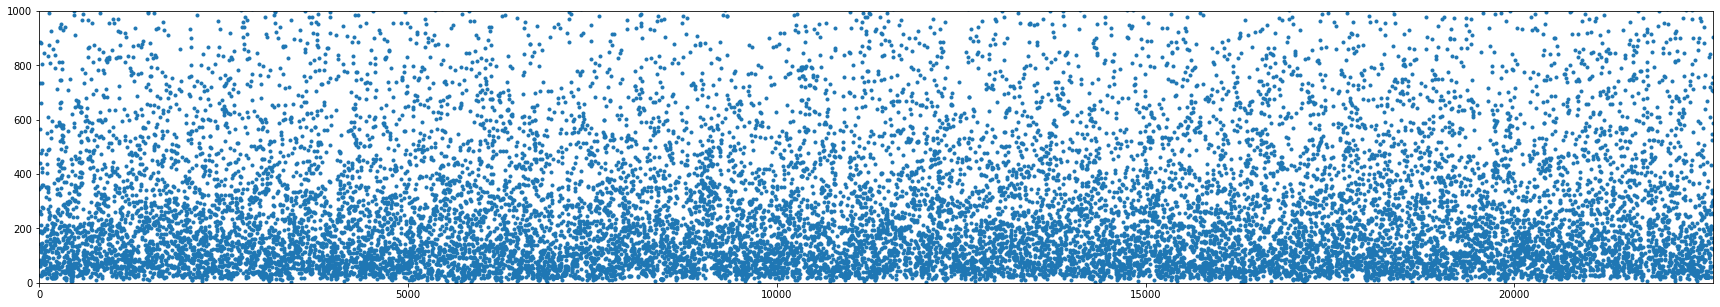

In [274]:
temp.plot(x='ClaimDate',y='ClaimAmount',style='.',figsize=(30,5),ylim=(0,1000))
#NOTE, must reset strftime dates?

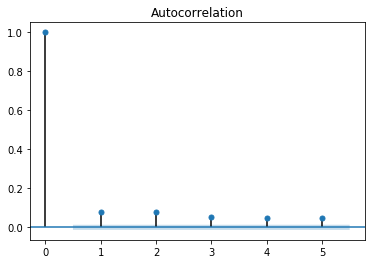

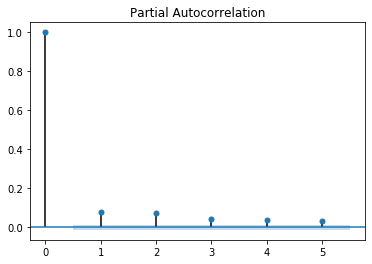

In [13]:
#set date as index
temp.set_index('ClaimDate')
temp = temp['ClaimAmount']
plot_acf(temp,lags=5)
plot_pacf(temp,lags=5)
plt.show()

In [14]:
claimdata['ClaimDate'] = claimdata['ClaimDate'].dt.strftime('%b %Y')

<h1>Pet Data</h1>

In [15]:
petdata=pd.read_csv('petdata.csv')

In [614]:
petdata['EnrollDate'] =  pd.to_datetime(petdata['EnrollDate'])
petdata['CancelDate'] =  pd.to_datetime(petdata['CancelDate'])
petdata['EnrollDate'] = petdata['EnrollDate'].dt.strftime('%b %Y')
petdata['CancelDate'] = petdata['CancelDate'].dt.strftime('%b %Y')

#NOTE, if CancelDate != p ==> prediction == 0
#Note, ~= 50% are closed accounts

#petdata.query('CancelDate == "NaT"')

#Data to Categorical
petdata['Species'] = petdata['Species'].astype('category')
petdata['AgeAtEnroll'] = petdata['AgeAtEnroll'].astype('category')
petdata['Breed'] = petdata['Breed'].astype('category')
petdata.info()


,PetId,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll
0,0,Aug 2015,Jul 2018,Dog,Mixed Breed,5 years old
1,1,Feb 2014,Jan 2016,Cat,Mixed Breed,3 years old
2,2,Dec 2014,NaT,Dog,French Bulldog,8 weeks to 12 months old
3,3,Jan 2015,Jan 2015,Dog,Mixed Breed,1 year old
4,4,Jul 2014,NaT,Cat,Mixed Breed,8 weeks to 12 months old
...,...,...,...,...,...,...
9995,9995,Feb 2019,NaT,Cat,Mixed Breed,6 years old
9996,9996,Dec 2016,Dec 2018,Cat,Mixed Breed,8 weeks to 12 months old
9997,9997,Jan 2015,Mar 2015,Dog,Mixed Breed,8 weeks to 12 months old
9998,9998,Nov 2015,NaT,Cat,Mixed Breed,8 weeks to 12 months old


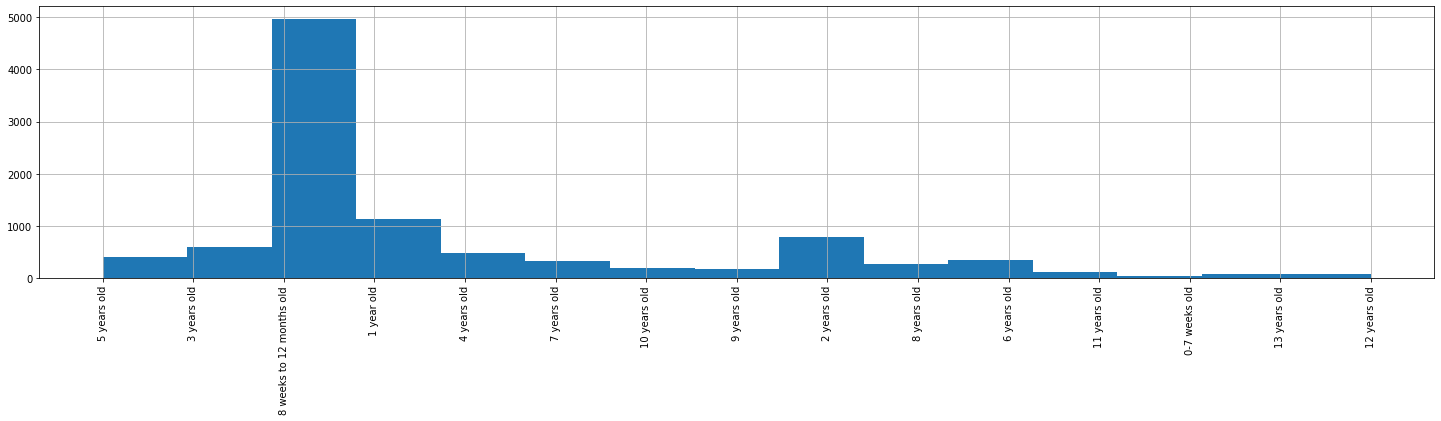

In [18]:

plt.xticks(rotation='vertical')
petdata['AgeAtEnroll'].hist(figsize=(25,5),bins=(len(petdata.AgeAtEnroll.unique())))


https://keras-pandas.readthedocs.io/en/latest/autosummary/data_types.Categorical.Categorical.html
    https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html

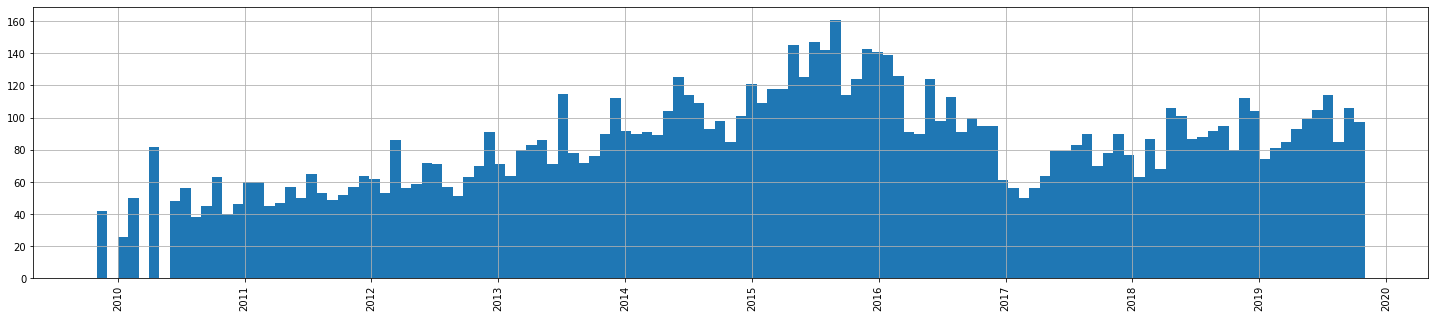

In [19]:
enroll_temp = petdata
#reset dates for sorting
enroll_temp.EnrollDate = pd.to_datetime(enroll_temp.EnrollDate)
enroll_temp.sort_index(inplace=True)
plt.xticks(rotation='vertical')
petdata['EnrollDate'].hist(figsize=(25,5),bins=(len(enroll_temp.EnrollDate.unique())))


In [20]:
petdata['EnrollDate'] = petdata['EnrollDate'].dt.strftime('%b %Y')
petdata

,PetId,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll
0,0,Aug 2015,Jul 2018,Dog,Mixed Breed,5 years old
1,1,Feb 2014,Jan 2016,Cat,Mixed Breed,3 years old
2,2,Dec 2014,NaT,Dog,French Bulldog,8 weeks to 12 months old
3,3,Jan 2015,Jan 2015,Dog,Mixed Breed,1 year old
4,4,Jul 2014,NaT,Cat,Mixed Breed,8 weeks to 12 months old
...,...,...,...,...,...,...
9995,9995,Feb 2019,NaT,Cat,Mixed Breed,6 years old
9996,9996,Dec 2016,Dec 2018,Cat,Mixed Breed,8 weeks to 12 months old
9997,9997,Jan 2015,Mar 2015,Dog,Mixed Breed,8 weeks to 12 months old
9998,9998,Nov 2015,NaT,Cat,Mixed Breed,8 weeks to 12 months old


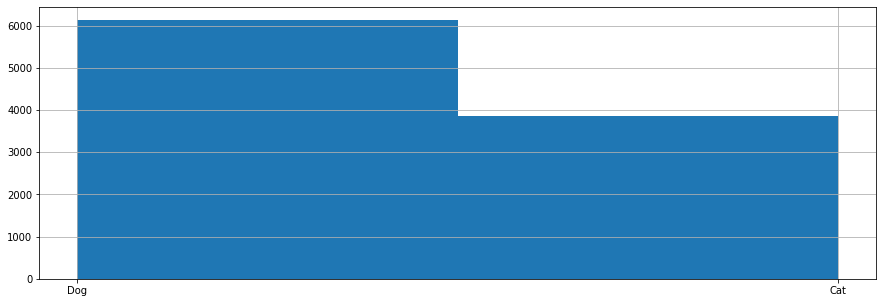

In [21]:
petdata['Species'].hist(figsize=(15,5),bins=(len(petdata.Species.unique())))

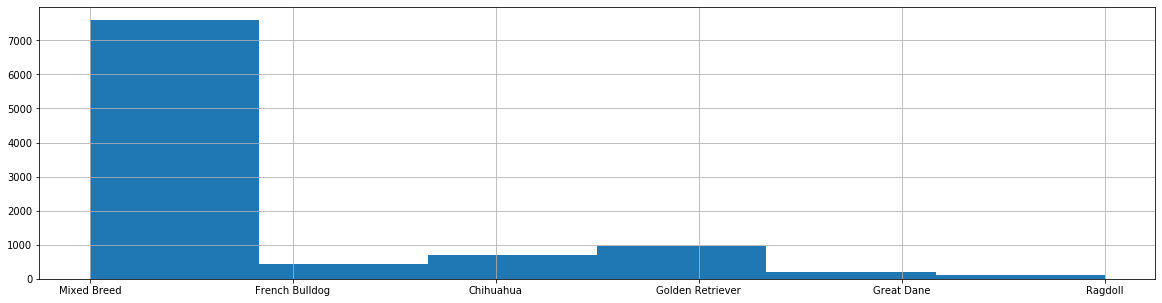

In [22]:
petdata['Breed'].hist(figsize=(20,5),bins=(len(petdata.Breed.unique())))

<h2>Combine Datasets</h2>

In [311]:
claim = claimdata.set_index('PetId')
pet = petdata.set_index('PetId')

In [630]:
training = claim.join(pet,on='PetId')
training

,ClaimDate,ClaimId,ClaimAmount,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll
PetId,,,,,,,,
2,Apr 2018,24729,347.0,Dec 2014,NaT,Dog,French Bulldog,8 weeks to 12 months old
2,Aug 2018,13987,191.0,Dec 2014,NaT,Dog,French Bulldog,8 weeks to 12 months old
2,Dec 2015,35612,75.0,Dec 2014,NaT,Dog,French Bulldog,8 weeks to 12 months old
2,Dec 2017,35613,567.0,Dec 2014,NaT,Dog,French Bulldog,8 weeks to 12 months old
2,Feb 2018,7633,83.0,Dec 2014,NaT,Dog,French Bulldog,8 weeks to 12 months old
...,...,...,...,...,...,...,...,...
9998,Dec 2016,35689,5939.0,Nov 2015,NaT,Cat,Mixed Breed,8 weeks to 12 months old
9998,Jul 2016,6869,300.0,Nov 2015,NaT,Cat,Mixed Breed,8 weeks to 12 months old
9998,Mar 2016,3260,588.0,Nov 2015,NaT,Cat,Mixed Breed,8 weeks to 12 months old


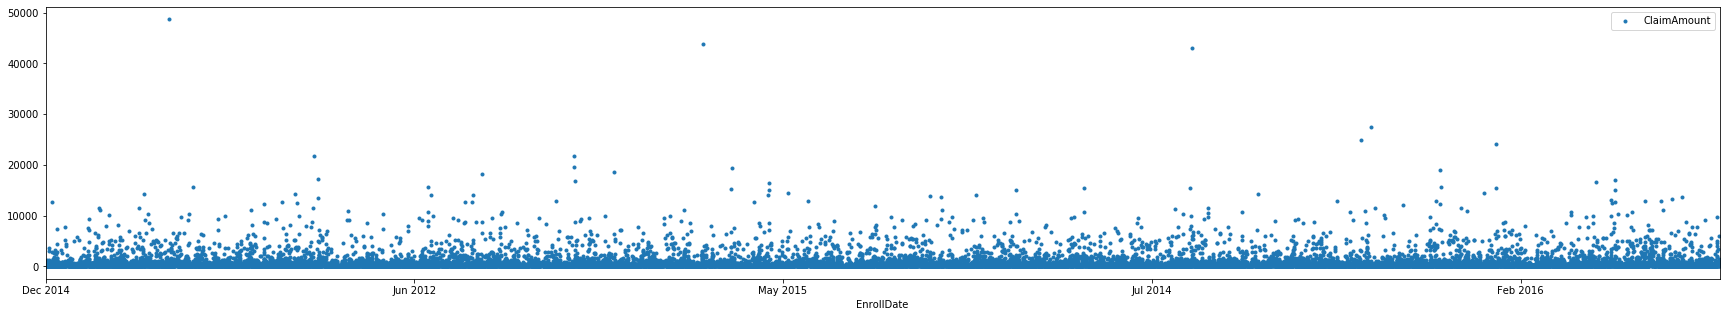

In [285]:
training.plot(x='EnrollDate',y='ClaimAmount',style='.',figsize=(30,5))

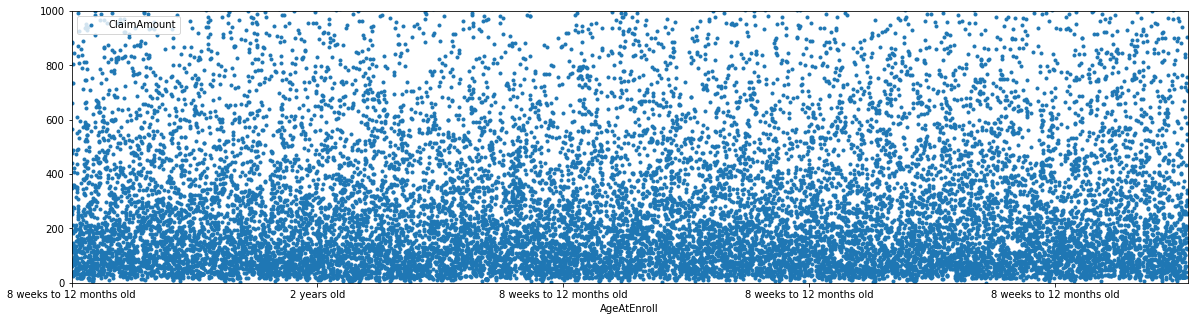

In [288]:
training.plot(x='AgeAtEnroll',y='ClaimAmount',style='.',figsize=(20,5),ylim=(0,1000))

<h2>Clean and Encode</h2>

In [609]:
#NOTE: Encodes first class with 0. Unsure of the effect

from sklearn.preprocessing import LabelEncoder

train_enc = training

lb_make = LabelEncoder()
train_enc["Breed"] = lb_make.fit_transform(train_enc["Breed"])
train_enc["Species"] = lb_make.fit_transform(train_enc["Species"])
train_enc["AgeAtEnroll"] = lb_make.fit_transform(train_enc["AgeAtEnroll"])

train_enc.AgeAtEnroll.unique()

array([12, 11,  1,  7, 13,  3,  9,  6,  8, 14,  2, 10,  4,  0,  5],
      dtype=int64)

In [610]:
#Helper function to make dates trainable

def date_features(df,date_col):
    df[date_col] =  pd.to_datetime(df[date_col])
    df[(date_col+'_m')] = df[date_col].dt.month
    df[(date_col+'_Y')] = df[date_col].dt.year
    df[(date_col+'_q')] = df[date_col].dt.quarter
    df = df.drop(columns=date_col)
    
    return(df)
train_enc = date_features(train_enc,'ClaimDate')
train_enc = date_features(train_enc,'EnrollDate')

## Toggle for prediction set off

train_enc = train_enc.drop(columns='CancelDate')


In [620]:
train_enc.query('CancelDate=="NaT"')

,ClaimId,ClaimAmount,CancelDate,Species,Breed,AgeAtEnroll,ClaimDate_m,ClaimDate_Y,ClaimDate_q,EnrollDate_m,EnrollDate_Y,EnrollDate_q
PetId,,,,,,,,,,,,
2,24729,347.0,NaT,1,1,12,4,2018,2,12,2014,4
2,13987,191.0,NaT,1,1,12,8,2018,3,12,2014,4
2,35612,75.0,NaT,1,1,12,12,2015,4,12,2014,4
2,35613,567.0,NaT,1,1,12,12,2017,4,12,2014,4
2,7633,83.0,NaT,1,1,12,2,2018,1,12,2014,4
...,...,...,...,...,...,...,...,...,...,...,...,...
9998,35689,5939.0,NaT,0,4,12,12,2016,4,11,2015,4
9998,6869,300.0,NaT,0,4,12,7,2016,3,11,2015,4
9998,3260,588.0,NaT,0,4,12,3,2016,1,11,2015,4


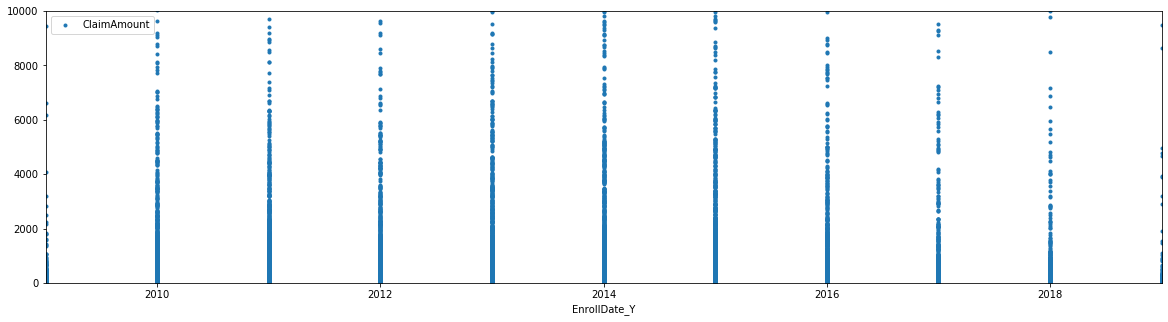

In [321]:
train_enc.plot(x='EnrollDate_Y',y='ClaimAmount',style='.',figsize=(20,5),ylim=(0,10000))

<h2>Balancing classes</h2>
<p>Breed and AgeAtEnroll are imbalanced</p>
<p>Options: <br>
Downsample (Concern for amount of data) <br>
Up sample (overfitting) <br>
Stick with random forests... (may not be accurate) <br>
PCA/Clustering to remove??</p>

In [473]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import OneSidedSelection

In [575]:
y = train_enc['ClaimAmount']
X = train_enc[['Species','Breed','AgeAtEnroll','ClaimDate_Y','ClaimDate_m','ClaimDate_q','EnrollDate_Y','EnrollDate_m','EnrollDate_q']]
X

<h2>Pick a balancing Algo</h2>

In [577]:
rus = RandomUnderSampler(random_state=42,sampling_strategy='majority')
X_rus, y_rus = rus.fit_sample(X, y)

#oss = OneSidedSelection(random_state=42)
#X_rus, y_rus = oss.fit_resample(X, y)

#ros = RandomOverSampler(random_state=42, sampling_strategy='not majority')
#X_rus, y_rus = ros.fit_resample(X, y)

#x_df = pd.DataFrame(X['AgeAtEnroll'])
#sm = SMOTE(random_state=42,sampling_strategy='minority')
##change names if it works
#X_rus_t, y_rus_t = sm.fit_resample(x_df, y)
#print('Resampled dataset shape %s' % Counter(y_res))

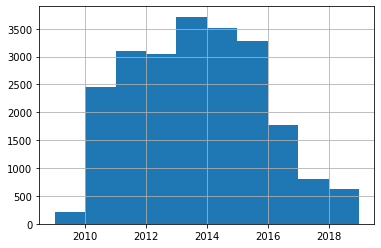

In [578]:
X_rus.EnrollDate_Y.hist()

<h2>Scale Classes</h2>

In [714]:
#Scale Classes
scaler = MinMaxScaler()
X_rus_scale = scaler.fit_transform(X_rus)
scaler = MinMaxScaler()
y_rus_scale = scaler.fit_transform(y_rus.values.reshape(-1,1))
y_rus_scale

array([[0.00000000e+00],
       [2.05380982e-05],
       [2.05380982e-05],
       ...,
       [8.82809612e-01],
       [9.02238653e-01],
       [1.00000000e+00]])

In [704]:
X_rus_scale

array([[0.        , 0.8       , 0.71428571, ..., 0.4       , 0.27272727,
        0.33333333],
       [1.        , 0.6       , 0.85714286, ..., 0.2       , 0.45454545,
        0.33333333],
       [1.        , 0.8       , 0.78571429, ..., 0.4       , 0.27272727,
        0.33333333],
       ...,
       [1.        , 0.8       , 0.64285714, ..., 0.4       , 0.36363636,
        0.33333333],
       [0.        , 0.8       , 0.85714286, ..., 0.3       , 0.        ,
        0.        ],
       [1.        , 0.8       , 0.85714286, ..., 0.1       , 0.45454545,
        0.33333333]])

<h2>Train Test Split</h2>

In [344]:
from sklearn.model_selection import train_test_split

In [715]:
X_train, X_test, y_train, y_test = train_test_split(
    X_rus_scale, y_rus_scale, test_size=0.33, random_state=42)

<h2>Model Development</h2>

<h3>XGBoost</h3>

In [549]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [582]:
reg_xgb = xgb.XGBRegressor(n_estimators=5000)
#Build the model
params = {
    "eta": 0.2,
    "max_depth": 4,
    "objective": "binary:logistic",
    "silent": 1,
    "base_score": np.mean(y_test),
    'n_estimators': 5000,
    "eval_metric": "logloss"
}
#odel = xgb.train(params, dt, 3000, [(dt, "train"),(dv, "valid")], verbose_eval=200)
reg_xgb.fit(X_train, y_train,verbose=True)

[15:46:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=5000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

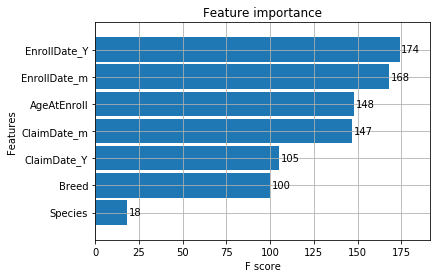

In [583]:
xgb.plot_importance(reg,height=0.9)

In [552]:
#XGB Results
X_test_pred = reg_xgb.predict(X_test)

mean_squared_error(y_test,X_test_pred)
#r2_score(y_test,lin_pred_y)

0.0009642022077200196

<h3>Linear Regression</h3>

In [397]:
from sklearn.linear_model import LogisticRegression
# Create linear regression object
regr = sk.linear_model.LinearRegression(n_jobs=10)

# Train the model using the training sets
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=10, normalize=False)

In [398]:
lin_pred_y = regr.predict(X_test)
mean_squared_error(y_test,lin_pred_y)
r2_score(y_test,lin_pred_y)

-0.002753213174083058

<h3>MLP</h3>

In [587]:
model = Sequential()
model.add(Dense(8, input_dim=9, kernel_initializer='normal', activation='relu'))
#model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_134 (Dense)            (None, 8)                 80        
_________________________________________________________________
dense_135 (Dense)            (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


In [588]:
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

In [589]:
history = model.fit(X_train, y_train, epochs=10, batch_size=100,  verbose=0, validation_split=0.3)
#50 #50

In [716]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

#Kfolds CV

kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []

for train, test in kfold.split(X_rus_scale, y_rus_scale):
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=9, kernel_initializer='normal', activation='relu'))
    #model.add(Dense(6, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
    # Fit the model
    history = model.fit(X_train, y_train, epochs=20, batch_size=100,  verbose=0, validation_split=0.3)
    # evaluate the model
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

mean_squared_error: 0.11%
mean_squared_error: 0.11%
mean_squared_error: 0.11%
mean_squared_error: 0.11%
mean_squared_error: 0.11%
mean_squared_error: 0.11%
mean_squared_error: 0.11%
mean_squared_error: 0.11%
mean_squared_error: 0.10%
mean_squared_error: 0.11%
0.11% (+/- 0.00%)


dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])


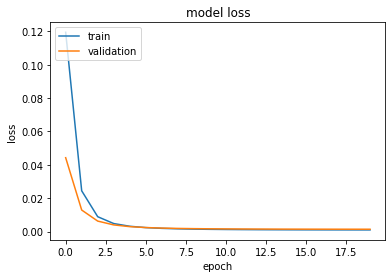

In [717]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

<h1>Predictions</h1>

In [697]:
#drop NaT
pred_training = training.query('CancelDate =="NaT"')
pred_training = pred_training.reset_index()
pred_training = pred_training.drop_duplicates(subset='PetId')
#Encode
lb_make = LabelEncoder()
pred_training["Breed"] = lb_make.fit_transform(pred_training["Breed"])
pred_training["Species"] = lb_make.fit_transform(pred_training["Species"])
pred_training["AgeAtEnroll"] = lb_make.fit_transform(pred_training["AgeAtEnroll"])
#Encode dates
pred_training = date_features(pred_training,'ClaimDate')
pred_training = date_features(pred_training,'EnrollDate')
pred_training
#Set July 2019
pred_training['ClaimDate_Y'] = 2019
pred_training['ClaimDate_m'] = 7
pred_training
#clean
pred_training = pred_training.drop(columns=['ClaimId','CancelDate','ClaimAmount'])
pred_training = pred_training.set_index('PetId')

#Normalize
X_input = scaler.fit_transform(pred_training)


array([[1.        , 0.2       , 0.85714286, ..., 1.        , 0.5       ,
        1.        ],
       [0.        , 0.8       , 0.85714286, ..., 0.54545455, 0.5       ,
        0.66666667],
       [1.        , 0.8       , 0.78571429, ..., 0.09090909, 0.4       ,
        0.        ],
       ...,
       [1.        , 0.2       , 0.64285714, ..., 0.27272727, 0.6       ,
        0.33333333],
       [0.        , 0.8       , 0.71428571, ..., 0.09090909, 1.        ,
        0.        ],
       [0.        , 0.8       , 0.85714286, ..., 0.90909091, 0.6       ,
        1.        ]])

In [759]:
pred_col = model.predict(X_input)
pred_training['predictions']= scaler.inverse_transform(pred_col)
predictions = pred_training['predictions'].round()
predictions = pd.DataFrame(predictions)

#set all unpredicted to 0
pet_preds = petdata
pet_preds['predictions'] = 0.0
pet_preds = pet_preds.set_index('PetId')
pet_preds = pet_preds.predictions
pet_preds = pd.DataFrame(pet_preds)


#predictions
#pet_preds
predictions

,predictions
PetId,
2,660.0
4,1247.0
15,1757.0
19,1006.0
25,1697.0
...,...
9987,843.0
9991,401.0
9992,1070.0


In [766]:
Final = pet_preds.join(predictions, on='PetId',rsuffix='_')
Finale = Final.predictions_.fillna(0.0)
Finale

PetId
0          0.0
1          0.0
2        660.0
3          0.0
4       1247.0
         ...  
9995    2463.0
9996       0.0
9997       0.0
9998     583.0
9999       0.0
Name: predictions_, Length: 10000, dtype: float32

In [767]:
Finale.to_csv('Predictions.csv')

C:\Users\D4rkmatter\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


<h1>BIG ASSUMPTION</h1>
<p>Assuming active accounts with no claims default to 0 <br>
Could try and force active accounts not in claims data (ClaimAmount =0) but unsure about ClaimDate...</p>

In [666]:
ff = petdata.query('CancelDate =="NaT"')

asdfas = pet.join(claim, on='PetId')

In [682]:
#BIG ASSUMPTION
## Active && no claim == predicted == 0

ff.PetId.unique()
no_claim= petdata.PetId.isin(claimdata.PetId.unique())
no_claim
hold['in']

0       False
1       False
2        True
3       False
4        True
        ...  
9995     True
9996     True
9997    False
9998     True
9999    False
Name: PetId, Length: 10000, dtype: bool

In [687]:
claimdata.query('ClaimAmount == "0.0"')

,ClaimId,PetId,ClaimDate,ClaimAmount
388,443,6430,Oct 2016,0.0
13442,14033,9633,Aug 2018,0.0


In [686]:
m = claimdata.PetId.unique()
len(m)

4027